In [14]:
import os
import json
import httpx
import re
import ast
from typing import Annotated, TypedDict, List, Dict, Any, Optional, Literal, Tuple
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field, ValidationError
from IPython.display import Image, display
import uuid
from dotenv import load_dotenv
import asyncio
import user_inputs

load_dotenv(override=True)

def extract_output_json_string(text: str) -> str:
    """
    Extract a JSON object/array string from various SLM output formats and
    auto-fix missing closing braces/brackets by balancing them.

    Output is intended to be fed directly into your existing _validate_model_output()
    without changing validation logic.
    """
    if not isinstance(text, str) or not text.strip():
        return ""

    s = text.strip()

    # Optional: strip code fences if present
    if s.startswith("```"):
        s = re.sub(r"^```[a-zA-Z0-9_-]*\s*", "", s)
        s = re.sub(r"\s*```$", "", s).strip()

    payload = None

    # Case A: assignment form: something = '...'
    m = re.search(r"""=\s*(['"])(?P<payload>.*)\1\s*$""", s, flags=re.DOTALL)
    if m:
        payload = m.group("payload")
    else:
        # Case B: the whole text is a quoted JSON string: '{ ... }'
        if (len(s) >= 2) and (s[0] in ("'", '"')):
            q = s[0]
            # If it ends with the same quote, strip both; otherwise strip only the leading quote
            if s.endswith(q):
                payload = s[1:-1]
            else:
                payload = s[1:]
        else:
            # Case C: maybe bare JSON already, or extra text with JSON inside
            payload = s

    payload = (payload or "").strip()

    # Unescape common sequences if JSON came from a Python-quoted string
    # (safe: JSON uses backslashes; this mainly helps when SLM prints literal "\n")
    payload = payload.replace("\\r\\n", "\n").replace("\\n", "\n").replace("\\t", "\t").strip()

    # If there's extra text before JSON, trim to first { or [
    start = None
    for i, ch in enumerate(payload):
        if ch in "{[":
            start = i
            break
    if start is None:
        return ""

    candidate = payload[start:].strip()

    # --------- Balance missing closing braces/brackets ----------
    # We scan outside of strings and keep a stack of expected closing chars.
    stack = []
    in_string = False
    escape = False

    for ch in candidate:
        if escape:
            escape = False
            continue

        if ch == "\\":
            # only meaningful inside strings, but harmless to track globally
            escape = True
            continue

        if ch == '"':
            in_string = not in_string
            continue

        if in_string:
            continue

        if ch == "{":
            stack.append("}")
        elif ch == "[":
            stack.append("]")
        elif ch == "}" or ch == "]":
            if stack and stack[-1] == ch:
                stack.pop()
            else:
                # stray closer; ignore (we won't try to "fix" this here)
                pass

    if stack:
        candidate = candidate + "".join(reversed(stack))

    # Also trim any trailing unmatched wrapper quote if it was included accidentally
    candidate = candidate.strip()
    if candidate and candidate[-1] in ("'", '"'):
        # Only remove if it looks like a dangling wrapper (common in your examples)
        # This won't affect _extract_first_bracket_value anyway, but keeps it clean.
        candidate = candidate[:-1].strip()

    return candidate


# If the text starts with triple backticks, removes the opening json and the closing
def _strip_code_fences(text: str) -> str:
    if not isinstance(text, str):
        return ""
    s = text.strip()
    if s.startswith("```"):
        s = re.sub(r"^```[a-zA-Z0-9_-]*\s*", "", s)
        s = re.sub(r"\s*```$", "", s)
    return s.strip()

# Finds the first { or [ in the cleaned text.
# Then walks forward keeping track of nested brackets until it finds the matching closing } or ].
# Returns that substring (the first complete JSON-like chunk).
def _extract_first_bracket_value(text: str) -> Optional[str]:
    s = _strip_code_fences(text)
    if not s:
        return None

    start = None
    open_char = None
    close_char = None
    for i, ch in enumerate(s):
        if ch == "{":
            start, open_char, close_char = i, "{", "}"
            break
        if ch == "[":
            start, open_char, close_char = i, "[", "]"
            break
    if start is None:
        return None

    depth = 0
    in_string = False
    escape = False
    for j in range(start, len(s)):
        ch = s[j]
        if escape:
            escape = False
            continue
        if ch == "\\":
            escape = True
            continue
        if ch == "\"":
            in_string = not in_string
            continue
        if in_string:
            continue

        if ch == open_char:
            depth += 1
        elif ch == close_char:
            depth -= 1
            if depth == 0:
                return s[start : j + 1]

    return None

# Uses _extract_first_bracket_value.
# Tries json.loads(snippet).
# If it fails, tries to parse as a Python literal using ast.literal_eval after converting JSON keywords (null/true/false) to Python ones.
def _parse_json_like(text: str) -> Any:
    snippet = _extract_first_bracket_value(text)
    if snippet is None:
        raise ValueError("No JSON-like object/array found in model output.")

    try:
        return json.loads(snippet)
    except json.JSONDecodeError:
        pass

    snippet_py = re.sub(r"\bnull\b", "None", snippet, flags=re.IGNORECASE)
    snippet_py = re.sub(r"\btrue\b", "True", snippet_py, flags=re.IGNORECASE)
    snippet_py = re.sub(r"\bfalse\b", "False", snippet_py, flags=re.IGNORECASE)
    return ast.literal_eval(snippet_py)

# Parses the text into a Python object (dict/list).
# Validates it with a Pydantic model and returns the model instance.
def _validate_model_output(model: type[BaseModel], text: str) -> BaseModel:
    data = _parse_json_like(text)
    return model.model_validate(data)

# ----------------------------
# State + Schema
# ----------------------------
class GraphState(TypedDict, total=False):
    messages: Annotated[List[Any], add_messages]
    constraints: Dict[str, Any]
    final_answer: str
    constraint_verification_status: str
    solver_verification_status: str
    constraint_verify_attempts: int
    solver_verify_attempts: int
    constraint_extractor_output: str
    solver_output: str
    formatted_output: str

def _get_first_human_message(state: GraphState) -> str:
    if "messages" in state and state["messages"]:
        for m in state["messages"]:
            if isinstance(m, HumanMessage):
                return m.content
    return ""

def _get_last_ai_message_by_name(state: GraphState, name: str) -> str:
    if "messages" in state and state["messages"]:
        for m in reversed(state["messages"]):
            if isinstance(m, AIMessage) and getattr(m, "name", None) == name:
                return m.content
    return ""

class BusyInterval(BaseModel):
    day: Literal["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"] = Field(
        description="Day of the week for the busy interval."
    )
    time: List[str] = Field(
        description="List of time intervals (start_time, end_time) in 24h 'H:MM' format (e.g., ['9:00', '9:30'])."
    )

class Agent1Output(BaseModel):
    day: List[Literal["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]] = Field(
        description="List of days of the week the scheduling request applies to (e.g., ['Monday', 'Wednesday'])."
    )

    work_hours: Tuple[str, str] = Field(
        description="Working-hour window as (start_time, end_time) in 24h 'H:MM' format (e.g., ('9:00','17:00'))."
    )

    duration_minutes: int = Field(ge=1, description="Required meeting duration in minutes (must be >= 1).")

    participants: List[str] = Field(min_length=1, description="List of participant names who must attend the meeting.")

    busy: Dict[str, List[BusyInterval]] = Field(
        description="Mapping from participant name to their busy time intervals for the given day. "
                    "Each interval contains 'day' and 'time' (start_time, end_time) in 24h 'H:MM' format."
    )


class Agent2Output(BaseModel):
    day: Literal[
        "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"
    ] = Field(
        description="Day of the week provided in the input json's 'day' field.",
        examples=["Monday"],
    )
    proposed_slot: Tuple[str, str] = Field(
        description=(
            "Proposed time window as a (start_time, end_time) tuple in 24-hour 'HH:MM' format. "
        ),
        examples=[("14:30", "15:30")],
    )

# ----------------------------
# OpenRouter via LangChain (Qwen2.5‑7B Instruct)
# ----------------------------
OPENROUTER_MODEL = "qwen/qwen-2.5-7b-instruct"  # Replace with Qwen2.5‑7B model slug

# OPENROUTER_MODEL = "meta-llama/llama-3.1-8b-instruct"

slm = ChatOpenAI(
    model=OPENROUTER_MODEL,                   # OpenRouter model slug for Qwen2.5‑7B
    base_url="https://openrouter.ai/api/v1",  # OpenRouter endpoint
    api_key=os.environ["OPENROUTER_API_KEY"], # your OpenRouter key
    temperature=0.0,
)

async def call_openrouter_qwen(system_prompt: str, user_text: str) -> str:
    """
    LangChain-based equivalent of your httpx OpenRouter call.
    Returns the raw model text (expected to be JSON).
    """
    resp = await slm.ainvoke(
        [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_text),
        ]
    )
    return resp.content or ""


# ----------------------------
# Node: constraint_extractor
# ----------------------------
async def constraint_extractor(state: GraphState) -> GraphState:
    system_prompt = (
            """You extract structured constraint information from natural-language calendar scheduling tasks.
    Return only a single JSON object (no Markdown, no code fences, no commentary) matching this shape:

    {
    "day": ["Wednesday"],
    "work_hours": ["9:00", "17:00"],
    "duration_minutes": 30,
    "participants": ["Tom", "Dick"],
    "busy": {
        "Tom": [{"day": "Monday", "time": ["12:00", "12:30"]}],
        "Dick": [{"day": "Monday", "time": ["9:00", "9:30"]}]
    }
    }

    - Use 24h 'H:MM' times.
    - 'day' must use full day names (Monday..Sunday).
    - 'work_hours' and each 'time' must be 2-element arrays: [start_time, end_time].

    Rules to handle preferences -
    Apart from the directly provided constraints, pay extra attention to any extra preferences by any of the participants. 
    This preference will usually be mentioned at the very end. Look for words like "rather", "do not", "avoid", "can not" etc
    Assuming work hour ends at 17:00,
    A text like "Dylan do not want to meet on Monday after 13:30", implies a new entry in "busy" field like {"day": "Monday", "time": ["13:30", "17:00"]}
    A text like "Dylan can not meet on Monday before 14:00", implies a new entry "busy" field like {"day": "Monday", "time": ["9:00", "14:00"]}
    A text like "Tom would rather not meet on Monday before 11:00", implies a new entry "busy" field like {"day": "Monday", "time": ["9:00", "11:00"]}

    Some examples with preferences at the end-
    EXAMPLE 1 :
    Input -
    Dylan and Samuel need to meet for half an hour between the work hours of 9:00 to 17:00 on Monday. \n\n
    Here are the existing schedules for everyone during the day: \n
    Dylan's calendar is wide open the entire day.\n
    Samuel is busy on Monday during 9:00 to 11:00, 11:30 to 13:00, 13:30 to 14:00, 14:30 to 16:00, 16:30 to 17:00; \n\n
    Dylan do not want to meet on Monday after 13:30.

    Output -
    {
    "day": ["Monday"],
    "work_hours": ["9:00", "17:00"],
    "duration_minutes": 30,
    "participants": ["Dylan", "Samuel"],
    "busy": {
        "Dylan": [
            { "day": "Monday", "time": ["13:30", "17:00"] }
        ],
        "Samuel": [
            { "day": "Monday", "time": ["9:00", "11:00"] },
            { "day": "Monday", "time": ["11:30", "13:00"] },
            { "day": "Monday", "time": ["13:30", "14:00"] },
            { "day": "Monday", "time": ["14:30", "16:00"] },
            { "day": "Monday", "time": ["16:30", "17:00"] }
        ]
            }
    }

    EXAMPLE 2 :
    Input -
    Joseph and Dylan need to meet for one hour between the work hours of 9:00 to 17:00 on Monday. \n\n
    Here are the existing schedules for everyone during the day: \n
    Joseph has blocked their calendar on Monday during 11:30 to 12:00, 15:30 to 17:00; \n
    Dylan has meetings on Monday during 9:00 to 10:30, 12:30 to 13:00, 13:30 to 14:30, 16:00 to 17:00; \n\n
    Dylan can not meet on Monday before 14:00.

    Output -
    {
    "day": ["Monday"],
    "work_hours": ["9:00", "17:00"],
    "duration_minutes": 60,
    "participants": ["Joseph", "Dylan"],
    "busy": {
        "Joseph": [
            { "day": "Monday", "time": ["11:30", "12:00"] },
            { "day": "Monday", "time": ["15:30", "17:00"] }
        ],
        "Dylan": [
            { "day": "Monday", "time": ["9:00", "10:30"] },
            { "day": "Monday", "time": ["12:30", "13:00"] },
            { "day": "Monday", "time": ["13:30", "14:30"] },
            { "day": "Monday", "time": ["16:00", "17:00"] },
            { "day": "Monday", "time": ["9:00", "14:00"] }
        ]
            }
    }

    """
        )


    # Get the latest human input (fallback: join all message contents)
    user_text = ""
    if "messages" in state and state["messages"]:
        # Prefer last HumanMessage content
        for m in reversed(state["messages"]):
            if isinstance(m, HumanMessage):
                user_text = m.content
                break

    # Call SLM via OpenRouter
    print(f'Input to constraint_extractor : {user_text}\n')
    response = await call_openrouter_qwen(system_prompt, user_text)

    raw_json_str = extract_output_json_string(response)

    # Validate against your schema (and keep raw if model deviates)
    constraints_dict: Dict[str, Any]
    try:
        constraints_dict = _validate_model_output(Agent1Output, raw_json_str).model_dump()
        ai_content = json.dumps(constraints_dict, ensure_ascii=False)
    except ValidationError as ve:
        constraints_dict = {
            "error": "Model output did not validate against Agent1Output schema.",
            "validation_error": json.loads(ve.json()),
            "raw": raw_json_str,
        }
        ai_content = json.dumps(constraints_dict, ensure_ascii=False)
    except (ValueError, json.JSONDecodeError, SyntaxError) as e:
        constraints_dict = {
            "error": "Could not parse model output as JSON.",
            "parse_error": str(e),
            "raw": raw_json_str,
        }
        ai_content = json.dumps(constraints_dict, ensure_ascii=False)

    sys_msg = SystemMessage(content=system_prompt)
    out_msg = AIMessage(content=ai_content, name="constraint_extractor")

    # Return as a State object (GraphState): messages + parsed constraints
    return {
        "messages": [sys_msg, out_msg],
        "constraints": constraints_dict,
        "constraint_extractor_output": ai_content,
    }



# ----------------------------
# Node: constraint_verification_agent
# ----------------------------
async def constraint_verification_agent(state: GraphState) -> GraphState:

    system_prompt = (
        """ 
        You are a strict JSON-only validator.

        Input will contain:
        1) ORIGINAL_TASK: a natural-language scheduling task.
        2) CONSTRAINTS: a JSON object with keys: day, work_hours, duration_minutes, participants, busy.

        Your job:
        - Verify that CONSTRAINTS exactly matches what is stated in ORIGINAL_TASK.
        - Check ALL of the following:
        A) day: same day(s) as stated.
        B) work_hours: same start/end times as stated.
        C) duration_minutes: same meeting length as stated (convert “half an hour” to 30).
        D) participants: same participant names as stated (same set; order does not matter).
        E) busy: for each participant, the busy time intervals must match exactly what ORIGINAL_TASK states:
            - Same number of intervals.
            - Each interval must have the correct day and correct start/end times.
            - No extra intervals, no missing intervals, no merged/expanded intervals, no altered times.
            - Times must be within the stated day context; do not infer additional blocks.
        - Treat any mismatch as INVALID.
        - If INVALID, list each mismatch as a separate reason. Be specific: mention the field path (e.g., "busy.Mark[1].time") and what is wrong.
        - Do NOT rewrite or “fix” the constraints. Only validate.

        Output rules (VERY IMPORTANT):
        - Output ONLY one JSON object (no markdown, no code fences, no extra text).
        - JSON shape must be exactly:
        {
            "status": "valid" | "invalid",
            "reasons": [string, ...]
        }
        - If valid: reasons must be ["All constraints match"].
        """
    )
    original_task = _get_first_human_message(state)
    last_ai = _get_last_ai_message_by_name(state, "constraint_extractor")
    if not last_ai:
        last_ai = state.get("constraint_extractor_output", "")

    # Create the requested system prompt
    user_text = f"""  
        Validate the following.

        ORIGINAL_TASK:
        {original_task}

        CONSTRAINTS:
        {last_ai}

        """

    # Call SLM via OpenRouter (returns plain text string, not guaranteed JSON)
    print(f'Input to constraint verification agent : {user_text}\n')
    response_text = await call_openrouter_qwen(system_prompt, user_text)
    # print(f'Raw output from constraint verification agent : {response_text}\n')
    json_formatted = json.loads(extract_output_json_string(response_text))
    print(f'Parsed JSON from constraint verification agent : {json_formatted}\n')

    status = json_formatted.get("status", "invalid").strip().lower()
    attempts = state.get("constraint_verify_attempts", 0) + 1
    return {
        "constraint_verification_status": status,
        "constraint_verify_attempts": attempts,
    }



# ----------------------------
# Node: solver_agent
# ----------------------------
async def solver_agent(state: GraphState) -> GraphState:

    system_prompt = (
        """
        You are a helpful time slot extracting assistant. You are provided with structured constraint list in JSON format as input.
        The JSON contains following fields: 
        day - The possible days on which the meeting can be scheduled
        work_hours - The working hours, applicable to all days
        duration_minutes - The duration of the meeting in minutes
        participants - The list of participants in the meeting
        busy - The day and time intervals when each participant is not available i.e busy
        Your only task is to propose a single day and time slot that works for everyone's schedule and constraints.

        IMPORTANT :
        1. All times are in 24-hour 'HH:MM' format.

        Strictly respond as a single JSON object (no Markdown, no code fences) like:
        {
            "day": "Monday",
            "proposed_slot": ["14:30", "15:30"]
        }

        Round off all times to the nearest multiple of 30 minutes. For example 12:27 should be rounded off to 12:30, 11:07 should be rounded off to 11:00 and so on.

        Examples -
        EXAMPLE 1 :
        Input -
        {
        "day": ["Monday"],
        "work_hours": ["9:00", "17:00"], # [start_time, end_time]
        "duration_minutes": 60, # duration in minutes
        "participants": ["Joseph", "Dylan"], # list of participants
        "busy": {
            "Joseph": [
                { "day": "Monday", "time": ["11:30", "12:00"] }, # This means Joseph is busy on Monday from 11:30 to 12:00
                { "day": "Monday", "time": ["15:30", "17:00"] }
            ],
            "Dylan": [
                { "day": "Monday", "time": ["9:00", "10:30"] }, # This means Dylan is busy on Monday from 9:00 to 10:30
                { "day": "Monday", "time": ["12:30", "13:00"] },
                { "day": "Monday", "time": ["13:30", "14:30"] },
                { "day": "Monday", "time": ["16:00", "17:00"] },
                { "day": "Monday", "time": ["9:00", "14:00"] }
            ]
                }
        }

        Output -
        {"day": "Monday", "proposed_slot": ["14:30", "15:30"]}

        The above output works because both Joseph and Dylan are available from 14:30 to 15:30 on Monday.
        """ 
    )

    user_text = state.get("constraint_extractor_output", "")
    if not user_text:
        user_text = _get_last_ai_message_by_name(state, "constraint_extractor")
    user_text = f'''{user_text}\n
    Find a time slot that works for everyone's schedule and constraints\n
    Strictly propose the earliest possible time slot (i.e always start checking from start of working hours i.e work_hours[0])
    '''

    # Call SLM via OpenRouter
    print(f'Input to solver : {user_text}\n')
    raw_json_str = await call_openrouter_qwen(system_prompt, user_text)

    # Validate against your schema (and keep raw if model deviates)
    constraints_dict: Dict[str, Any]
    try:
        constraints_dict = _validate_model_output(Agent2Output, raw_json_str).model_dump()
        ai_content = json.dumps(constraints_dict, ensure_ascii=False)
    except ValidationError as ve:
        constraints_dict = {
            "error": "Model output did not validate against Agent2Output schema.",
            "validation_error": json.loads(ve.json()),
            "raw": raw_json_str,
        }
        ai_content = json.dumps(constraints_dict, ensure_ascii=False)
    except (ValueError, json.JSONDecodeError, SyntaxError) as e:
        constraints_dict = {
            "error": "Could not parse model output as JSON.",
            "parse_error": str(e),
            "raw": raw_json_str,
        }
        ai_content = json.dumps(constraints_dict, ensure_ascii=False)

    sys_msg = SystemMessage(content=system_prompt)
    out_msg = AIMessage(content=ai_content, name="solver_agent")

    # Return as a State object (GraphState): messages + parsed constraints
    return {
        "messages": [sys_msg, out_msg],
        "solver_output": ai_content,
    }

# ----------------------------
# Node: solver_verification_agent
# ----------------------------
async def solver_verification_agent(state: GraphState) -> GraphState:

    system_prompt = (
        """  
        You are a schedule-slot validator.

        TASK
        Given:
        (1) a constraints JSON object (with fields: day, work_hours, duration_minutes, participants, busy)
        (2) a proposed slot JSON object (with fields: day, proposed_slot)
        You must determine whether the proposed slot conflicts with any participant’s busy intervals on that day.

        REFERENCE PYTHON FUNCTION (fixed, do not change)
        Input to this function:
        - constraints: the first JSON object (dict)
        - proposed: the second JSON object (dict)
        It returns exactly "valid" or "invalid".

        ```python
        def validate_slot(constraints: dict, proposed: dict) -> str:
            day = proposed["day"]
            s, e = proposed["proposed_slot"]  # ["HH:MM", "HH:MM"]

            def to_minutes(t: str) -> int:
                h, m = t.split(":")
                return int(h) * 60 + int(m)

            s_m = to_minutes(s)
            e_m = to_minutes(e)

            # Check all participants' busy intervals for the same day
            for person in constraints["participants"]:
                for item in constraints["busy"].get(person, []):
                    if item["day"] != day:
                        continue
                    b_s, b_e = item["time"]
                    b_s_m = to_minutes(b_s)
                    b_e_m = to_minutes(b_e)

                    # Half-open overlap check: [s,e) overlaps [b_s,b_e) if s < b_e and e > b_s
                    if s_m < b_e_m and e_m > b_s_m:
                        return "invalid"

            return "valid"

        INSTRUCTIONS :

        Read the two JSON objects from the user message (constraints first, proposed second).
        Apply the exact logic of validate_slot() to decide the result.
        Strictly output ONLY ONE WORD: valid OR invalid.
        No JSON, no explanation, no extra text.

        """
    )
    last_ai = _get_last_ai_message_by_name(state, "solver_agent")
    if not last_ai:
        last_ai = state.get("solver_output", "")
    second_last_ai = _get_last_ai_message_by_name(state, "constraint_extractor")
    if not second_last_ai:
        second_last_ai = state.get("constraint_extractor_output", "")

    # Create the requested system prompt
    user_text = f"""  
        Below is a list of day and time slots where each of the participants are not available =>\n
        {second_last_ai}\n

        Below is the proposed day and time slot =>\n
        {last_ai}
        Verify if the proposed day and time slot works for everyone's schedule and constraints."""

    # Call SLM via OpenRouter (returns plain text string, not guaranteed JSON)
    print(f'Input to solver verification agent : {user_text}\n')
    response_text = await call_openrouter_qwen(system_prompt, user_text)
    status = response_text.strip().lower()
    attempts = state.get("solver_verify_attempts", 0) + 1

    return {
        "solver_verification_status": status,
        "solver_verify_attempts": attempts,
    }

# ----------------------------
# Node: formatting_agent
# ----------------------------
async def formatting_agent(state: GraphState) -> GraphState:
    system_prompt = (
    """ 
    You are a formatting agent. 
    You will always receive JSON input exactly following below structure :
    {'day': 'Wednesday', 'proposed_slot': ('14:30', '15:00')}
    Your sole purpose is to parse this simple format and create a sentence of a fixed structure. 
    Here are a few examples :
    Example 1 :
    Input -
    {'day': 'Wednesday', 'proposed_slot': ('14:30', '15:00')}
    Output -
    Here is the proposed time: Wednesday, 14:30 - 15:00
    Example 2 :
    Input -
    {'day': 'Tuesday', 'proposed_slot': ('15:30', '17:00')}
    Output -
    Here is the proposed time: Tuesday, 15:30 - 17:00    
    """
    )

    user_text = state.get("solver_output", "")
    if not user_text:
        user_text = _get_last_ai_message_by_name(state, "solver_agent")

    # Call SLM via OpenRouter (returns plain text string, not guaranteed JSON)
    print(f'Input to formatter : {user_text}\n')
    response_text: str = await call_openrouter_qwen(system_prompt, user_text)

    # If you still want to *validate* a MeetingSlot somewhere, do it in a different node.
    # The formatting agent should output the final canonical string, so we store it as-is.
    sys_msg = SystemMessage(content=system_prompt)
    out_msg = AIMessage(content=response_text, name="formatting_agent")

    # Return as State; keep output also under a convenient field
    return {
        "messages": [sys_msg, out_msg],
        "final_answer": response_text,   # optional: add this key to GraphState if you want
        "formatted_output": response_text,
    }


async def check_constraint_verification(state: "GraphState") -> str:
    status = state.get("constraint_verification_status", "invalid")
    attempts = state.get("constraint_verify_attempts", 0)
    if status == "valid":
        return "valid"
    if attempts >= 4:
        return "valid"
    return "invalid"

async def check_solver_verification(state: "GraphState") -> str:
    status = state.get("solver_verification_status", "invalid")
    attempts = state.get("solver_verify_attempts", 0)
    if status == "valid":
        return "valid"
    if attempts >= 4:
        return "valid"
    return "invalid"




In [15]:
# ----------------------------
# Build + run graph
# ----------------------------
builder = StateGraph(GraphState)

builder.add_node("constraint_extractor", constraint_extractor)
builder.add_node("constraint_verification_agent",constraint_verification_agent)
builder.add_node("solver_agent",solver_agent)
builder.add_node("solver_verification_agent",solver_verification_agent)
builder.add_node("formatting_agent", formatting_agent)

builder.add_edge(START, "constraint_extractor")
builder.add_edge("constraint_extractor", "constraint_verification_agent")
builder.add_conditional_edges(
    "constraint_verification_agent",
    check_constraint_verification,
    {"valid": "solver_agent", "invalid": "constraint_extractor"},
)
builder.add_edge("solver_agent", "solver_verification_agent")
builder.add_conditional_edges(
    "solver_verification_agent",
    check_solver_verification,
    {"valid": "formatting_agent", "invalid": "solver_agent"},
)
builder.add_edge("formatting_agent", END)

graph = builder.compile()

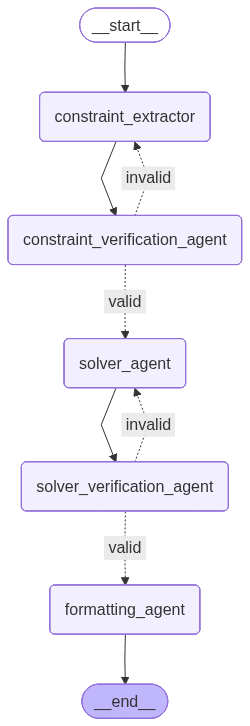

In [16]:
display(Image(graph.get_graph().draw_mermaid_png()))